In [1]:
import os
from glob import glob
import numpy as np
import fitsio
from scipy.ndimage import gaussian_filter1d
from matplotlib import pyplot as plt
from time import time
from astropy.io import fits
import pandas as pd
from astropy.cosmology import Planck18
from tqdm import tqdm
from astropy.table import Table
from multiprocessing import Pool
import matplotlib as mpl
from scipy import integrate
from scipy.interpolate import interp1d

In [2]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))

In [3]:
ardir = os.path.join(os.getenv("PSCRATCH", "/pscratch/sd/z/zhaozhon"))#
def get_ws(ardir):
    fn = sorted(
        glob(os.path.join(ardir, "pernight-spectra","desi-ztf-qso-iron-*-*.fits"))
    )[0]
    ws = fitsio.read(fn, "BRZ_WAVE")
    return ws
def get_tid_tileids_nights(tid, all_tids, all_tileids, all_nights):
    sel = all_tids == tid
    return all_tileids[sel], all_nights[sel]
def get_indiv_spectra(tid, tileids, nights, ardir, nwave):

    nobs = len(tileids)

    # read the spectra
    fs = np.zeros((nobs, nwave))  # flux
    ivs = np.zeros((nobs, nwave))  # inverse variance

    # loop on (tileids, nights)
    for i, (tileid, night) in enumerate(zip(tileids, nights)):

        fn = os.path.join(
            ardir,"pernight-spectra",
            "desi-ztf-qso-iron-{}-{}.fits".format(tileid, night),
        )

        # first get the row corresponding to TARGETID
        # (for a given TILEID, a TARGETID can appear only once max.)
        tmp_fm = fitsio.read(fn, "FIBERMAP", columns=["TARGETID"])
        tmp_i = np.where(tmp_fm["TARGETID"] == tid)[0][0]

        # now read the flux, ivar only for that row

        # this is more intuitive, but it loads the whole image first,
        #   then extracts the relevant row, so it s ~slow
        # fs[i, :] = fitsio.read(fn, "BRZ_FLUX")[tmp_i, :]
        # ivs[i, :] = fitsio.read(fn, "BRZ_IVAR")[tmp_i, :]

        # this way is *much* faster, with reading only the relevant row
        #   note: fitsio wants/works with a slice, not an integer...
        h = fitsio.FITS(fn)
        tmp_slice = slice(tmp_i, tmp_i + 1, 1)
        fs[i, :] = h["BRZ_FLUX"][tmp_slice, :]
        ivs[i, :] = h["BRZ_IVAR"][tmp_slice, :]

    return fs, ivs

In [4]:
ws = get_ws(ardir)
nwave = len(ws)

In [5]:
print(ws)

[3600.  3600.8 3601.6 ... 9822.4 9823.2 9824. ]


In [6]:
all_fs1 = []
# Define the wavelength bins
new_ws1 = np.arange(3600, 8013, 1)
# Loop through each targetid that meets the redshift condition
ii = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
z0 = 2.1

def process_target(i):
    tileids, nights = get_tid_tileids_nights(d['TARGETID'][i], d["TARGETID"], d["TILEID"], d["NIGHT"])
    mu = d['MU'][i]
    z = d['Z'][i]
    fs, ivs = get_indiv_spectra(d['TARGETID'][i], tileids, nights, ardir, nwave)
    
    # Select valid spectra
    SEL = (ivs != 0).all(axis=0)
    fs = (fs[:, SEL] * ivs[:, SEL]).sum(axis=0) / ivs[:, SEL].sum(axis=0)
    
    # Convert the spectrum to z=z0
    fs1 = fs * (1 + z) / (1 + z0) * 10**(mu / 2.5)
    ws1 = ws[SEL] * (1 + z0) / (1 + z)
    
    # Interpolate to new wavelength bins
    new_fs1 = np.interp(new_ws1, ws1, fs1)
    return new_fs1
if __name__ == '__main__':
    with Pool(processes=32) as pool:
        results = list(tqdm(pool.imap(process_target, ii), total=len(ii)))

    all_fs1 = np.array(results)

'''
for i in tqdm(ii):
    tileids, nights = get_tid_tileids_nights(d['TARGETID'][i], d["TARGETID"], d["TILEID"], d["NIGHT"])
    mu = d['MU'][i]
    z = d['Z'][i]
    fs, ivs = get_indiv_spectra(d['TARGETID'][i], tileids, nights, ardir, nwave)
    
    # Select valid spectra
    SEL = (ivs != 0).all(axis=0)
    fs = (fs[:, SEL] * ivs[:, SEL]).sum(axis=0) / ivs[:, SEL].sum(axis=0)
    
    # Convert the spectrum to z=z0
    fs1 = fs * (1 + z) / (1 + z0) * 10**(mu / 2.5)
    ws1 = ws[SEL] * (1 + z0) / (1 + z)
    #print(fs1)
    # Interpolate to new wavelength bins
    interp_func = interp1d(ws1, fs1, kind='cubic', fill_value='extrapolate')
    new_fs1 = interp_func(new_ws1)
    #new_fs1 = np.interp(new_ws1, ws1, fs1)
    #print(ws1)
    #print(fs1)
    #print(new_fs1)
    # Plotting the spectra on different canvases
    plt.figure(figsize=(10, 6))
    plt.plot(ws1, fs1, label='Original Spectrum', color='blue', linestyle='-', linewidth=1)
    plt.xlabel('Wavelength (Å)', fontsize=14)
    plt.ylabel('Flux', fontsize=14)
    plt.title(f'Original Spectrum for TARGETID {d["TARGETID"][i]}', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(new_ws1, new_fs1, label='Interpolated Spectrum', color='green', linestyle='--', linewidth=1)
    plt.xlabel('Wavelength (Å)', fontsize=14)
    plt.ylabel('Flux', fontsize=14)
    plt.title(f'Interpolated Spectrum for TARGETID {d["TARGETID"][i]}', fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()
    all_fs1.append(new_fs1)
    '''

100%|██████████| 400880/400880 [05:54<00:00, 1132.32it/s]


'\nfor i in tqdm(ii):\n    tileids, nights = get_tid_tileids_nights(d[\'TARGETID\'][i], d["TARGETID"], d["TILEID"], d["NIGHT"])\n    mu = d[\'MU\'][i]\n    z = d[\'Z\'][i]\n    fs, ivs = get_indiv_spectra(d[\'TARGETID\'][i], tileids, nights, ardir, nwave)\n    \n    # Select valid spectra\n    SEL = (ivs != 0).all(axis=0)\n    fs = (fs[:, SEL] * ivs[:, SEL]).sum(axis=0) / ivs[:, SEL].sum(axis=0)\n    \n    # Convert the spectrum to z=z0\n    fs1 = fs * (1 + z) / (1 + z0) * 10**(mu / 2.5)\n    ws1 = ws[SEL] * (1 + z0) / (1 + z)\n    #print(fs1)\n    # Interpolate to new wavelength bins\n    interp_func = interp1d(ws1, fs1, kind=\'cubic\', fill_value=\'extrapolate\')\n    new_fs1 = interp_func(new_ws1)\n    #new_fs1 = np.interp(new_ws1, ws1, fs1)\n    #print(ws1)\n    #print(fs1)\n    #print(new_fs1)\n    # Plotting the spectra on different canvases\n    plt.figure(figsize=(10, 6))\n    plt.plot(ws1, fs1, label=\'Original Spectrum\', color=\'blue\', linestyle=\'-\', linewidth=1)\n    plt

In [7]:
all_fs1 = np.array(all_fs1)

In [8]:
print(all_fs1.shape)

(400880, 4413)


In [9]:
dispersion = np.std(all_fs1, axis=0)

In [10]:
print(dispersion.shape)

(4413,)


In [11]:
print(dispersion)

[1.32470672e+19 1.33675997e+19 1.34577757e+19 ... 5.77146416e+18
 5.87686286e+18 5.94016273e+18]


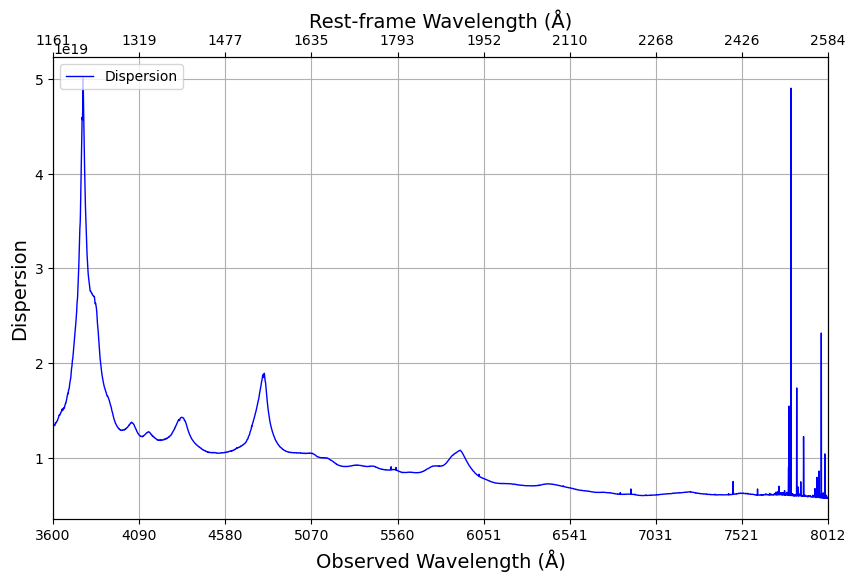

In [14]:
# Define rest-frame wavelength
restframe_ws = new_ws1 / (1 + z0)

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the dispersion with respect to the observed wavelength
ax1.plot(new_ws1, dispersion, label='Dispersion', color='blue', linestyle='-', linewidth=1)
ax1.set_xlabel('Observed Wavelength (Å)', fontsize=14)
ax1.set_ylabel('Dispersion', fontsize=14)
ax1.grid(True)
ax1.legend(loc='upper left')

# Manually set the limits for both x-axes
obs_min, obs_max = new_ws1.min(), new_ws1.max()
rest_min, rest_max = restframe_ws.min(), restframe_ws.max()

ax1.set_xlim(obs_min, obs_max)

# Create a secondary x-axis for the rest-frame wavelength
ax2 = ax1.twiny()
ax2.set_xlim(obs_min, obs_max)

# Define the ticks for both axes
obs_ticks = np.linspace(obs_min, obs_max, num=10)
rest_ticks = obs_ticks / (1 + z0)

# Set the ticks and labels for the primary x-axis (observed wavelength)
ax1.set_xticks(obs_ticks)
ax1.set_xticklabels(np.round(obs_ticks, 1).astype(int))

# Set the ticks and labels for the secondary x-axis (rest-frame wavelength)
ax2.set_xticks(obs_ticks)
ax2.set_xticklabels(np.round(rest_ticks, 1).astype(int))
ax2.set_xlabel('Rest-frame Wavelength (Å)', fontsize=14)

plt.show()